In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-29 21:39:16.232038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 21:39:17.526041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
# Load the data
file_path = "/home/yadu/Desktop/data.csv"
data = pd.read_csv(file_path)

In [10]:
print(data)

       pixel_0000  pixel_0001  pixel_0002  pixel_0003  pixel_0004  pixel_0005  \
0               0           0           0           0           0           0   
1               0           0           0           0           0           0   
2               0           0           0           0           0           0   
3               0           0           0           0           0           0   
4               0           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
91995           0           0           0           0           0           0   
91996           0           0           0           0           0           0   
91997           0           0           0           0           0           0   
91998           0           0           0           0           0           0   
91999           0           0           0           0           0           0   

       pixel_0006  pixel_00

In [11]:
# Data exploration and preprocessing
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [12]:
# Scale pixel values between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

In [14]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [15]:
# Reshape data for CNN
img_height, img_width = 32, 32
X_train_cnn = X_train.reshape(-1, img_height, img_width, 1)
X_test_cnn = X_test.reshape(-1, img_height, img_width, 1)


In [17]:
# CNN Model
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [27]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture with formatted output
print("\n=== Model Summary ===\n")
model.summary()
print("\n====================\n")



=== Model Summary ===



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,854 (1.31 MB)

 Trainable params: 343,854 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training the model
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


In [20]:
history = model.fit(X_train_cnn, y_train_encoded, batch_size=32, epochs=20,
                    validation_data=(X_test_cnn, y_test_encoded), callbacks=[checkpoint, early_stop])


Epoch 1/20


2024-04-29 21:39:59.988119: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 263782400 exceeds 10% of free system memory.


2010/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6056 - loss: 1.4615

2024-04-29 21:40:41.037100: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113049600 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.92141, saving model to best_model.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - accuracy: 0.6060 - loss: 1.4601 - val_accuracy: 0.9214 - val_loss: 0.2632
Epoch 2/20
2010/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9251 - loss: 0.2408
Epoch 2: val_accuracy improved from 0.92141 to 0.95236, saving model to best_model.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9252 - loss: 0.2408 - val_accuracy: 0.9524 - val_loss: 0.1583
Epoch 3/20
2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9494 - loss: 0.1548
Epoch 3: val_accuracy improved from 0.95236 to 0.96261, saving model to best_model.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - accuracy: 0.9494 - loss: 0.1548 - val_accuracy: 0.9626 - val_loss: 0.1231
Epoch 4/20
2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9633 - loss: 0.1125
Epoch 4: val_accuracy improved from 0.96261 to 0.96609, saving model to best_model.keras
2013/2013 ━━━━━━

In [23]:
# Model evaluation
loss, accuracy = model.evaluate(X_test_cnn, y_test_encoded)
print("Model Evaluation:")
print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


 15/863 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9729 - loss: 0.0931

2024-04-29 21:54:01.665893: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113049600 exceeds 10% of free system memory.


863/863 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9796 - loss: 0.0778
Model Evaluation:
Test Loss:     0.0798
Test Accuracy: 0.9789


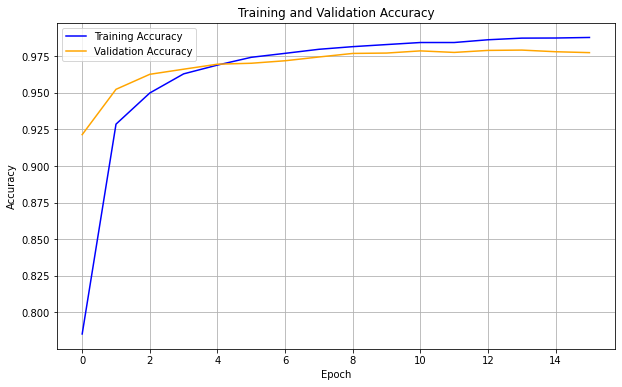

In [24]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


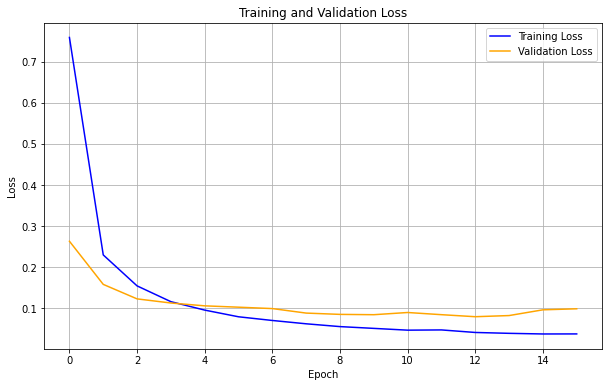

In [25]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Classification report
class_report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

Classification Report:
                           precision    recall  f1-score   support

          character_01_ka       0.99      0.99      0.99       605
         character_02_kha       0.99      0.98      0.98       591
          character_03_ga       0.99      0.99      0.99       567
         character_04_gha       0.94      0.97      0.96       603
         character_05_kna       0.99      0.97      0.98       618
         character_06_cha       0.98      0.99      0.99       598
        character_07_chha       0.96      0.98      0.97       566
          character_08_ja       0.98      0.99      0.98       601
         character_09_jha       1.00      0.98      0.99       594
         character_10_yna       0.99      0.97      0.98       570
    character_11_taamatar       0.98      0.95      0.97       621
        character_12_thaa       0.98      0.99      0.98       567
         character_13_daa       0.97      0.98      0.98       605
        character_14_dhaa       0.96  